# SEO Content Quality & Duplicate Detector

## Overview
This notebook implements a comprehensive SEO content analysis pipeline to:
1. **Parse and clean text** from HTML content
2. **Extract NLP and SEO features** (readability, word count, keywords)
3. **Detect duplicate/near-duplicate pages** using semantic similarity
4. **Classify content quality** (Low / Medium / High) using machine learning

## Pipeline Architecture
```
HTML Content → Text Extraction → Feature Engineering → Duplicate Detection → Quality Classification
```

## 1️⃣ Dependencies & Setup

In [1]:
# Install required packages if needed
import subprocess
import sys

required = ['sentence-transformers', 'textstat']
for pkg in required:
    try:
        __import__(pkg.replace('-', '_'))
    except ImportError:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg])

# Import all libraries
import pandas as pd
import numpy as np
import re
import pickle
from bs4 import BeautifulSoup
import textstat
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import warnings

nltk.download('punkt', quiet=True)
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette('husl')

print('✅ All imports completed successfully!')

✅ All imports completed successfully!


## 2️⃣ Load Dataset

In [3]:
# Load the dataset
df = pd.read_csv('../data/data.csv')
print(f'Dataset shape: {df.shape}')
print(f'Columns: {list(df.columns)}')
print('\nFirst few rows:')
df.head()

Dataset shape: (81, 2)
Columns: ['url', 'html_content']

First few rows:


,url,html_content
0,https://www.cm-alliance.com/cybersecurity-blog,"<!doctype html><!--[if lt IE 7]> <html class=""..."
1,https://www.varonis.com/blog/cybersecurity-tips,"<!doctype html><html lang=""en""><head>\n <me..."
2,https://www.cisecurity.org/insights/blog/11-cy...,<!DOCTYPE html><html data-unhead-vue-server-re...
3,https://www.cisa.gov/topics/cybersecurity-best...,"\n\n<!DOCTYPE html>\n<html lang=""en"" dir=""ltr""..."
4,https://www.qnbtrust.bank/Resources/Learning-C...,NaN


## 3️⃣ HTML Parsing & Text Extraction

Parsing HTML content...

✅ Successfully parsed 69 pages
Mean word count: 33581.3
Saved to: data/extracted_content.csv


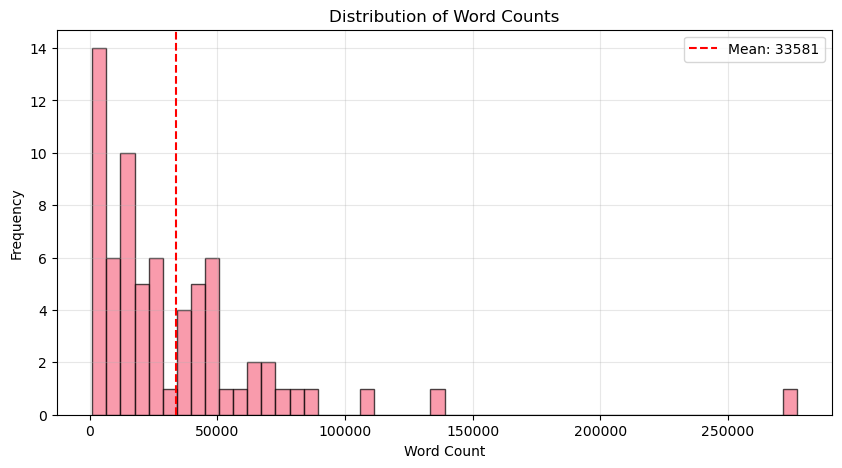

In [5]:
def parse_html_content(html_content):
    '''Extract clean text from HTML'''
    try:
        soup = BeautifulSoup(html_content, 'html.parser')
        
        # Remove script and style
        for script in soup(['script', 'style']):
            script.extract()
        
        # Extract title
        title_tag = soup.find('title')
        title = title_tag.get_text().strip() if title_tag else ''
        
        # Extract text
        content_tags = soup.find_all(['p', 'article', 'main', 'div', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6'])
        texts = [tag.get_text().strip() for tag in content_tags 
                 if tag.get_text().strip() and len(tag.get_text().strip()) > 10]
        
        clean_text = ' '.join(texts)
        clean_text = re.sub(r'\s+', ' ', clean_text).strip()
        word_count = len(clean_text.split())
        
        return {'title': title, 'clean_text': clean_text, 'word_count': word_count}
    except:
        return {'title': '', 'clean_text': '', 'word_count': 0}

# Parse all HTML content
print('Parsing HTML content...')
parsed_data = []
for idx, row in df.iterrows():
    result = parse_html_content(row['html_content'])
    result['url'] = row['url']
    parsed_data.append(result)
    if (idx + 1) % 100 == 0:
        print(f'Processed {idx + 1}/{len(df)} pages')

extracted_df = pd.DataFrame(parsed_data)
extracted_df = extracted_df[extracted_df['word_count'] > 0]

print(f'\n✅ Successfully parsed {len(extracted_df)} pages')
print(f'Mean word count: {extracted_df["word_count"].mean():.1f}')

# Save
extracted_df.to_csv('../data/extracted_content.csv', index=False)
print('Saved to: data/extracted_content.csv')

# Plot
plt.figure(figsize=(10, 5))
plt.hist(extracted_df['word_count'], bins=50, alpha=0.7, edgecolor='black')
plt.axvline(extracted_df['word_count'].mean(), color='red', linestyle='--', 
            label=f'Mean: {extracted_df["word_count"].mean():.0f}')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 4️⃣ Feature Engineering

Engineering features...

Generating embeddings (this may take a while)...


Batches:   0%|          | 0/3 [00:00<?, ?it/s]


✅ Features extracted successfully!
                                                 url  word_count  \
0     https://www.cm-alliance.com/cybersecurity-blog       47804   
1    https://www.varonis.com/blog/cybersecurity-tips       20295   
2  https://www.cisecurity.org/insights/blog/11-cy...       16118   
3  https://www.cisa.gov/topics/cybersecurity-best...       13832   
4  https://nordlayer.com/learn/network-security/b...       27194   

   sentence_count  readability  
0            2206    30.147102  
1            1181    31.694848  
2             875    22.467681  
3             608    -1.629109  
4            2051     4.268374  


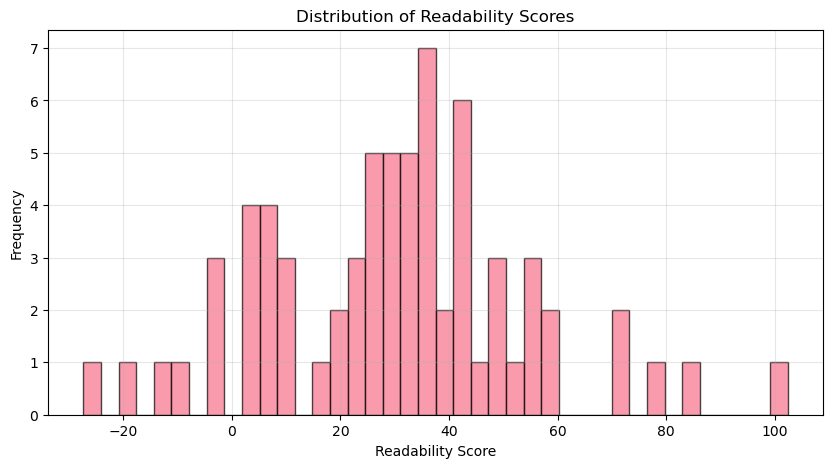

In [7]:
print('Engineering features...')

# Calculate features
features_list = []
for idx, row in extracted_df.iterrows():
    text = row['clean_text']
    
    # Sentence count
    sentences = re.split(r'[.!?]+', text)
    sentence_count = len([s for s in sentences if s.strip()])
    
    # Readability
    try:
        readability = textstat.flesch_reading_ease(text)
    except:
        readability = 50
    
    features_list.append({
        'url': row['url'],
        'word_count': row['word_count'],
        'sentence_count': sentence_count,
        'readability': readability,
        'clean_text': text
    })
    
    if (idx + 1) % 100 == 0:
        print(f'Processed {idx + 1}/{len(extracted_df)} pages')

features_df = pd.DataFrame(features_list)

# Generate embeddings
print('\nGenerating embeddings (this may take a while)...')
model = SentenceTransformer('all-MiniLM-L6-v2')
texts = features_df['clean_text'].head(min(1000, len(features_df))).tolist()
embeddings = model.encode(texts, show_progress_bar=True)

print('\n✅ Features extracted successfully!')
print(features_df[['url', 'word_count', 'sentence_count', 'readability']].head())

# Plot readability
plt.figure(figsize=(10, 5))
plt.hist(features_df['readability'], bins=40, alpha=0.7, edgecolor='black')
plt.xlabel('Readability Score')
plt.ylabel('Frequency')
plt.title('Distribution of Readability Scores')
plt.grid(True, alpha=0.3)
plt.show()

## 5️⃣ Duplicate Detection

In [9]:
print('Detecting duplicates...')

# Calculate cosine similarity
similarity_matrix = cosine_similarity(embeddings)

# Find duplicates (similarity > 0.8)
duplicates_list = []
n = len(similarity_matrix)
for i in range(n):
    for j in range(i + 1, n):
        if similarity_matrix[i][j] > 0.8:
            duplicates_list.append({
                'url_1': features_df.iloc[i]['url'],
                'url_2': features_df.iloc[j]['url'],
                'similarity': similarity_matrix[i][j]
            })

duplicates_df = pd.DataFrame(duplicates_list)

print(f'\n✅ Found {len(duplicates_df)} duplicate pairs')
if len(duplicates_df) > 0:
    print(duplicates_df.head(10))
    duplicates_df.to_csv('../data/duplicates.csv', index=False)
    print('Saved to: data/duplicates.csv')
else:
    # Create empty file
    pd.DataFrame(columns=['url_1', 'url_2', 'similarity']).to_csv('../data/duplicates.csv', index=False)
    print('No duplicates found')

Detecting duplicates...

✅ Found 70 duplicate pairs
                                               url_1  \
0  https://www.fortinet.com/resources/cyberglossa...   
1  https://www.fortinet.com/resources/cyberglossa...   
2             https://www.phriendlyphishing.com/blog   
3               https://en.wikipedia.org/wiki/SD-WAN   
4               https://en.wikipedia.org/wiki/SD-WAN   
5               https://en.wikipedia.org/wiki/SD-WAN   
6               https://en.wikipedia.org/wiki/SD-WAN   
7               https://en.wikipedia.org/wiki/SD-WAN   
8               https://en.wikipedia.org/wiki/SD-WAN   
9               https://en.wikipedia.org/wiki/SD-WAN   

                                               url_2  similarity  
0  https://www.fortinet.com/resources/cyberglossa...    1.000000  
1  https://www.fortinet.com/solutions/enterprise-...    1.000000  
2  https://inspiredelearning.com/blog/phishing-pr...    0.809915  
3  https://en.wikipedia.org/wiki/Remote_desktop_s...    1.00000

## 6️⃣ Quality Labeling

Quality distribution:
quality_label
Low       33
Medium    30
High       6
Name: count, dtype: int64


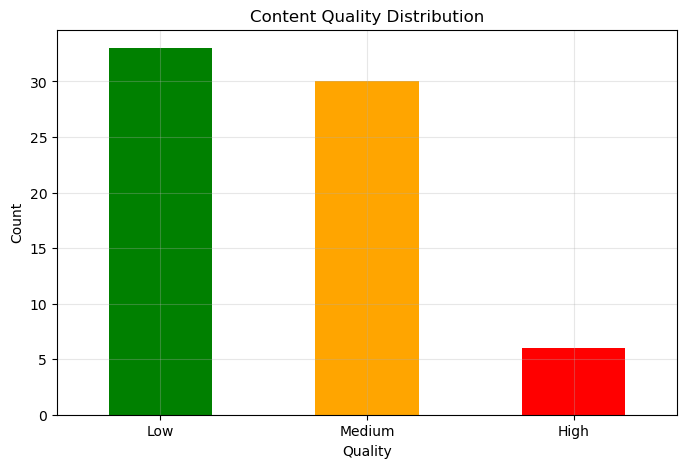


Saved to: data/features.csv


In [11]:
def assign_quality_label(row):
    '''Assign quality label based on rules'''
    word_count = row['word_count']
    readability = row['readability']
    
    if word_count > 1500 and 50 <= readability <= 70:
        return 'High'
    elif word_count < 500 or readability < 30:
        return 'Low'
    else:
        return 'Medium'

features_df['quality_label'] = features_df.apply(assign_quality_label, axis=1)

print('Quality distribution:')
print(features_df['quality_label'].value_counts())

# Plot
plt.figure(figsize=(8, 5))
features_df['quality_label'].value_counts().plot(kind='bar', color=['green', 'orange', 'red'])
plt.xlabel('Quality')
plt.ylabel('Count')
plt.title('Content Quality Distribution')
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3)
plt.show()

# Save features
features_df.to_csv('../data/features.csv', index=False)
print('\nSaved to: data/features.csv')

## 7️⃣ Model Training

Training ML model...

✅ Model trained!
Accuracy: 0.857
F1-Score: 0.851

Classification Report:
              precision    recall  f1-score   support

        High       1.00      0.50      0.67         2
         Low       0.80      1.00      0.89         8
      Medium       0.90      0.82      0.86        11

    accuracy                           0.86        21
   macro avg       0.90      0.77      0.80        21
weighted avg       0.87      0.86      0.85        21



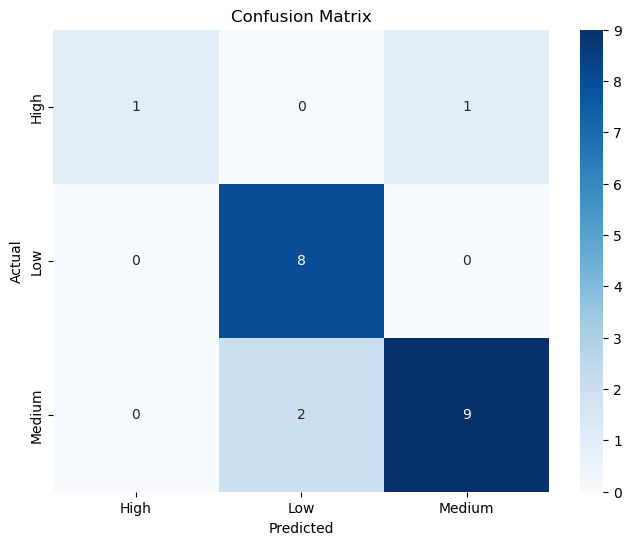


Feature Importance:
          feature  importance
2     readability    0.593325
1  sentence_count    0.210342
0      word_count    0.196333

Model saved to: models/quality_model.pkl


In [13]:
print('Training ML model...')

# Prepare data
X = features_df[['word_count', 'sentence_count', 'readability']]
y = features_df['quality_label']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'\n✅ Model trained!')
print(f'Accuracy: {accuracy:.3f}')
print(f'F1-Score: {f1:.3f}')
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Feature importance
importance = pd.DataFrame({
    'feature': ['word_count', 'sentence_count', 'readability'],
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print('\nFeature Importance:')
print(importance)

# Save model
with open('../models/quality_model.pkl', 'wb') as f:
    pickle.dump(model, f)
print('\nModel saved to: models/quality_model.pkl')

## 8️⃣ Summary

In [15]:
print('='*60)
print('📊 PIPELINE EXECUTION SUMMARY')
print('='*60)
print(f'✅ Pages analyzed: {len(extracted_df)}')
print(f'✅ Average word count: {features_df["word_count"].mean():.0f}')
print(f'✅ Duplicate pairs: {len(duplicates_df)}')
print(f'✅ Model accuracy: {accuracy:.3f}')
print(f'✅ Model F1-score: {f1:.3f}')
print('\nQuality Distribution:')
print(features_df['quality_label'].value_counts())
print('\nFiles Created:')
print('  • data/extracted_content.csv')
print('  • data/features.csv')
print('  • data/duplicates.csv')
print('  • models/quality_model.pkl')
print('\n🎉 Pipeline completed successfully!')
print('\n▶️  Next step: Run the Streamlit dashboard')
print('   Command: streamlit run app.py')
print('='*60)

📊 PIPELINE EXECUTION SUMMARY
✅ Pages analyzed: 69
✅ Average word count: 33581
✅ Duplicate pairs: 70
✅ Model accuracy: 0.857
✅ Model F1-score: 0.851

Quality Distribution:
quality_label
Low       33
Medium    30
High       6
Name: count, dtype: int64

Files Created:
  • data/extracted_content.csv
  • data/features.csv
  • data/duplicates.csv
  • models/quality_model.pkl

🎉 Pipeline completed successfully!

▶️  Next step: Run the Streamlit dashboard
   Command: streamlit run app.py
